In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Prerequisites

## 1. np.power 

first array elements raised to powers from second array, element-wise.

In [13]:
x1 = range(6)
x2 = [1.0, 2.0, 3.0, 3.0, 2.0, 1.0]

In [14]:
np.power(x1, 3)

array([  0,   1,   8,  27,  64, 125])

In [15]:
np.power(x1, x2)

array([ 0.,  1.,  8., 27., 16.,  5.])

## 2. np.vstack 

Stack arrays in sequence vertically (row wise) 
- input: tup-sequence of ndarrays
- output: ndarray

In [17]:
np.vstack((x1,x2))

array([[0., 1., 2., 3., 4., 5.],
       [1., 2., 3., 3., 2., 1.]])

## 3. np.linspace(start, stop, num=50, endpoint=True)

Return evenly spaced numbers over a specified interval.

In [20]:
np.linspace(2, 10, num=5)

array([ 2.,  4.,  6.,  8., 10.])

# GAN

reference: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/406_GAN.py

## Hyper Parameters

In [2]:
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas

## Upper and lower bound from real data

### one painting has 15 samples

In [30]:
x = np.linspace(-1, 1, ART_COMPONENTS)
print(x.shape)

(15,)


### real paintings 

- upper bound = $ 2x^{2}+1 $ 

- lower bound = $ x^{2}$

- real painting = $ ax^{2} + a - 1, a \in (1,2)$

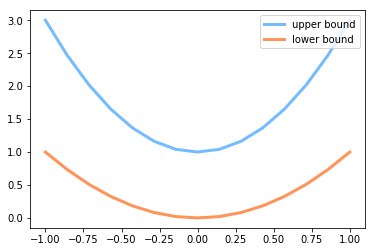

In [37]:
plt.plot(x,2 * np.power(x, 2) + 1,c='#74BCFF', lw=3, label='upper bound')
plt.plot(x, 1 * np.power(x, 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right', fontsize=10)

### simultaneously training 64 paintings once

In [3]:
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])
print(PAINT_POINTS.shape) 

(64, 15)


### real painting generation 

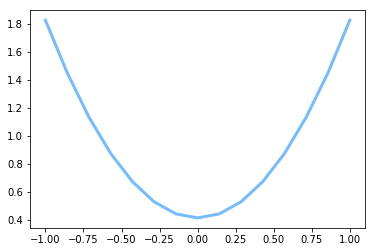

In [38]:
a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
plt.plot(PAINT_POINTS[0],paintings[0],c='#74BCFF', lw=3, label='upper bound')

### Real painting  

In [5]:
def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    paintings = torch.from_numpy(paintings).float()
    return paintings

## G&D Model

In [6]:
G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS, 128),            # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS, 128),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)


## Optimazation function 

In [7]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

## Training part

#### minimax game 

\begin{align}
\min_{G}\max_{D}V(D,G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] -\mathbb{E}_{z \sim p_{z}(z)} [\log(1-D(G(z)))] \end{align}

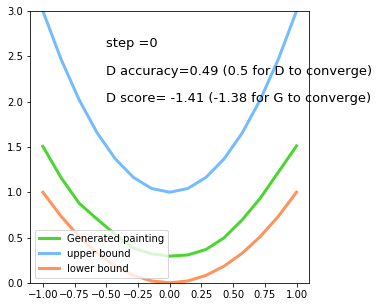

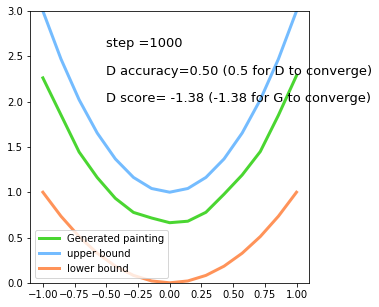

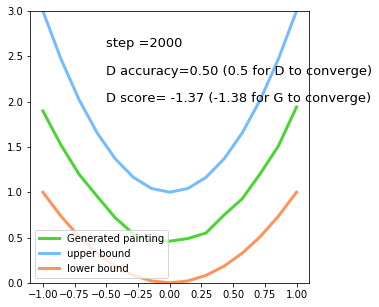

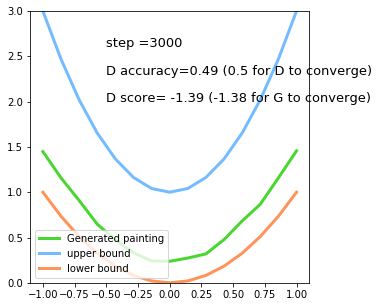

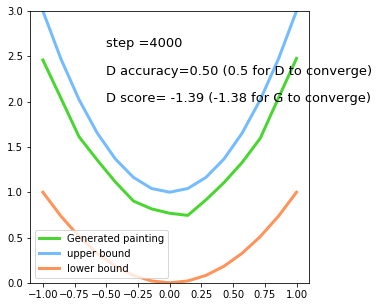

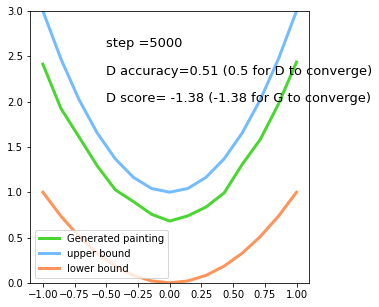

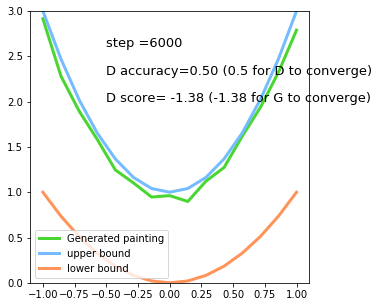

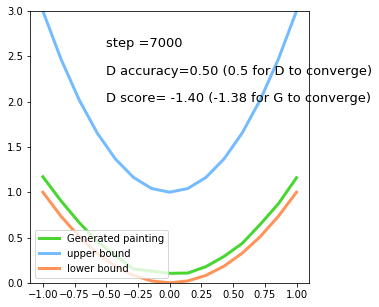

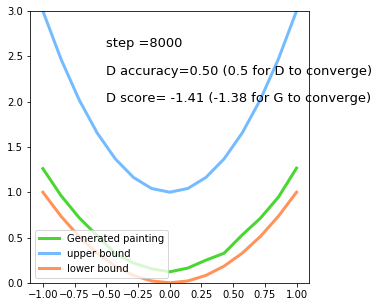

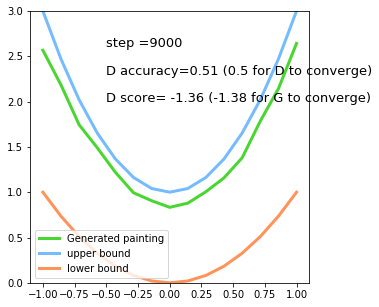

In [29]:
for step in range(10000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)  # random ideas
    G_paintings = G(G_ideas)                    # fake painting from G (random ideas)

    prob_real_artist = D(artist_paintings)          # D try to increase this prob
    prob_fake_artist = D(G_paintings)               # D try to reduce this prob

    
    D_loss = - torch.mean(torch.log(prob_real_artist) + torch.log(1 - prob_fake_artist))
    G_loss = torch.mean(torch.log(1. - prob_fake_artist))

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 1000 == 0:  # plotting
        plt.figure(figsize=(5,5))
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting')
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.6,'step =%i '% step, fontdict={'size': 13})
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_real_artist.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((0, 3))
        plt.legend(loc='lower left', fontsize=10)
        plt.show()